In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
# import isodata
import os
from tqdm import tqdm

# import gridstatus

In [81]:
%load_ext autoreload
%autoreload 2
from data_utils import PATH_HOME, PATH_DATA, CAISO
from data_utils import readin_caiso_lmp
from battery_utils import get_optimal_battery_schedule, get_rt_efficiency
from plot_utils import set_plt_settings, plot_optimal_performance, plot_optimal_rev_by_duration

set_plt_settings()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
# read in data
data = readin_caiso_lmp(market='REAL_TIME_15_MIN')

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]


In [66]:
nodes = data.location.unique()
pn = data.lmp[data.location == nodes[0]].to_numpy() # prices are $/MWh 
ps = data.lmp[data.location == nodes[1]].to_numpy() # prices are $/MWh
pc = data.lmp[data.location == nodes[2]].to_numpy() # prices are $/MWh

# 1. Evaluate battery performances

In [92]:
# settings
durations = [4, 6, 8, 12, 24, 48, 100]
capacity = 200
t = 365*4*24
y = 0
dt_start = pd.to_datetime(data.time[t*y]).date()

## 1.a Revenue over a year, by battery duration (actual efficiencies)

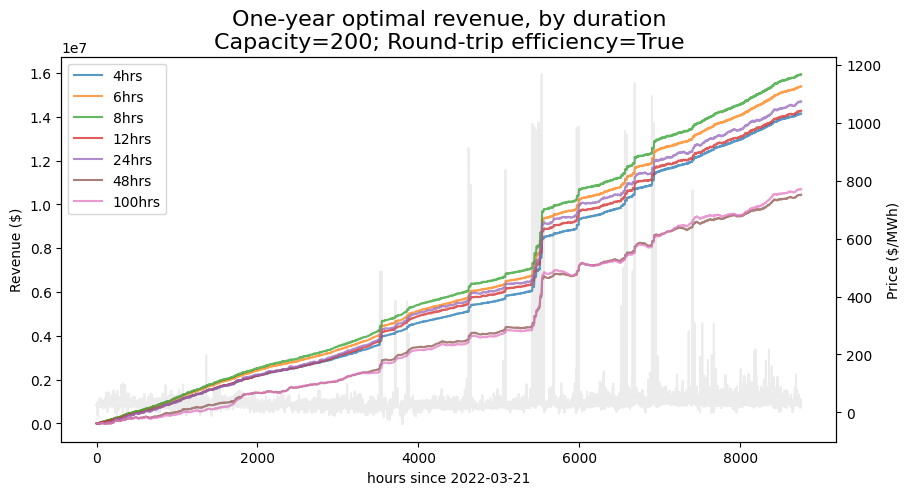

In [239]:
plot_optimal_rev_by_duration(pn[t*y:t*(y+1)], dt_start, durations, capacity, True)

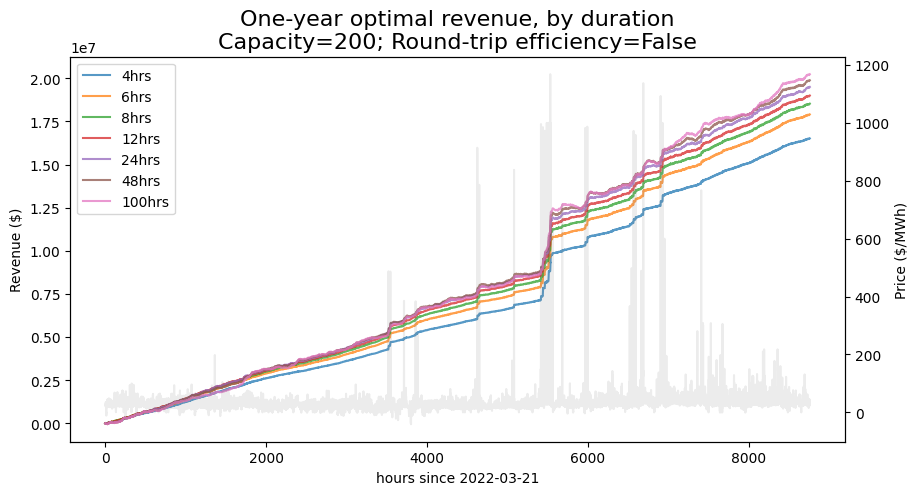

In [240]:
plot_optimal_rev_by_duration(pn[t*y:t*(y+1)], dt_start, durations, capacity, False)

## 1.b Battery schedule

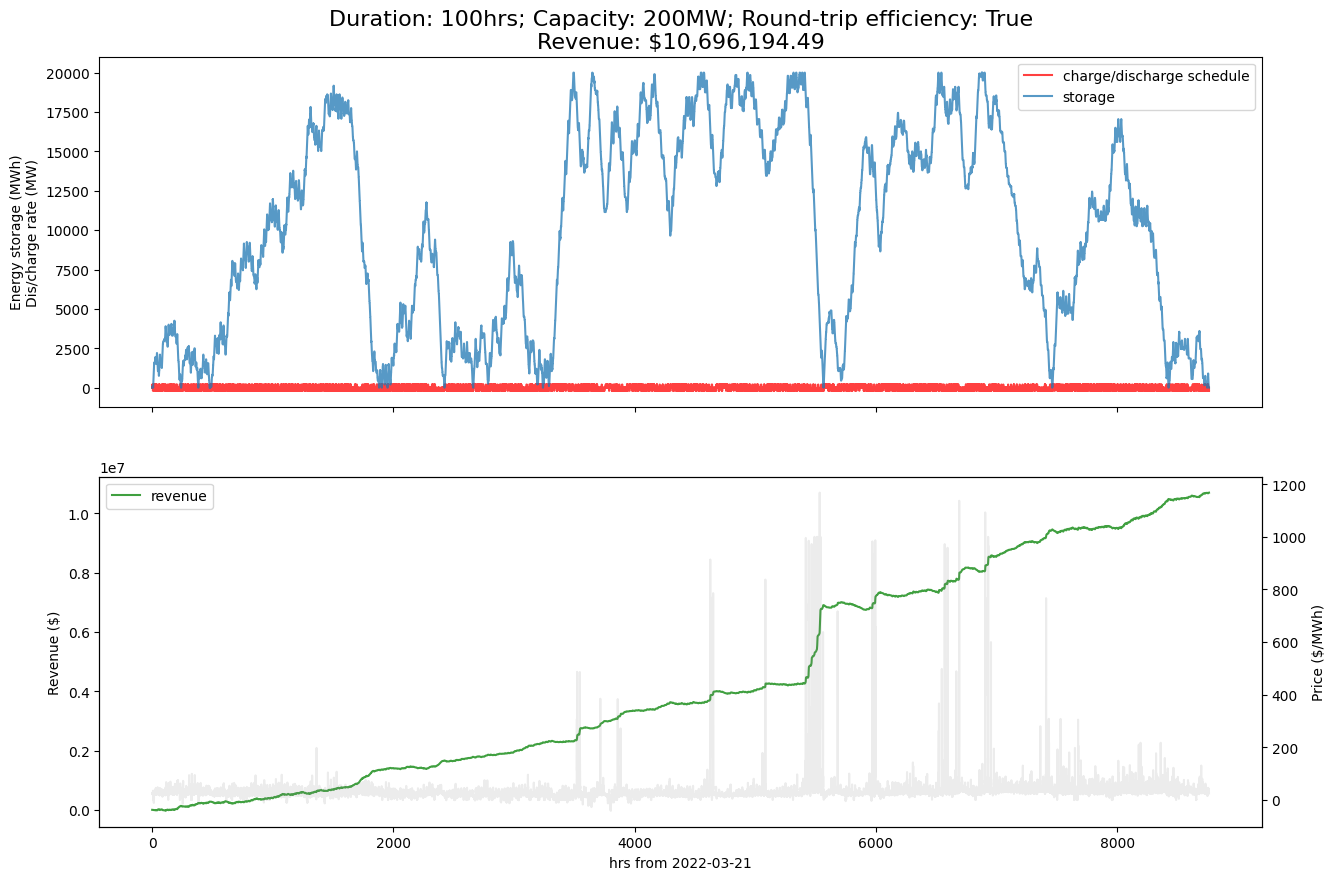

In [241]:
plot_optimal_performance(pn[t*y:t*(y+1)], dt_start=dt_start, 
                         duration=100, capacity=capacity, use_efficiency=True)

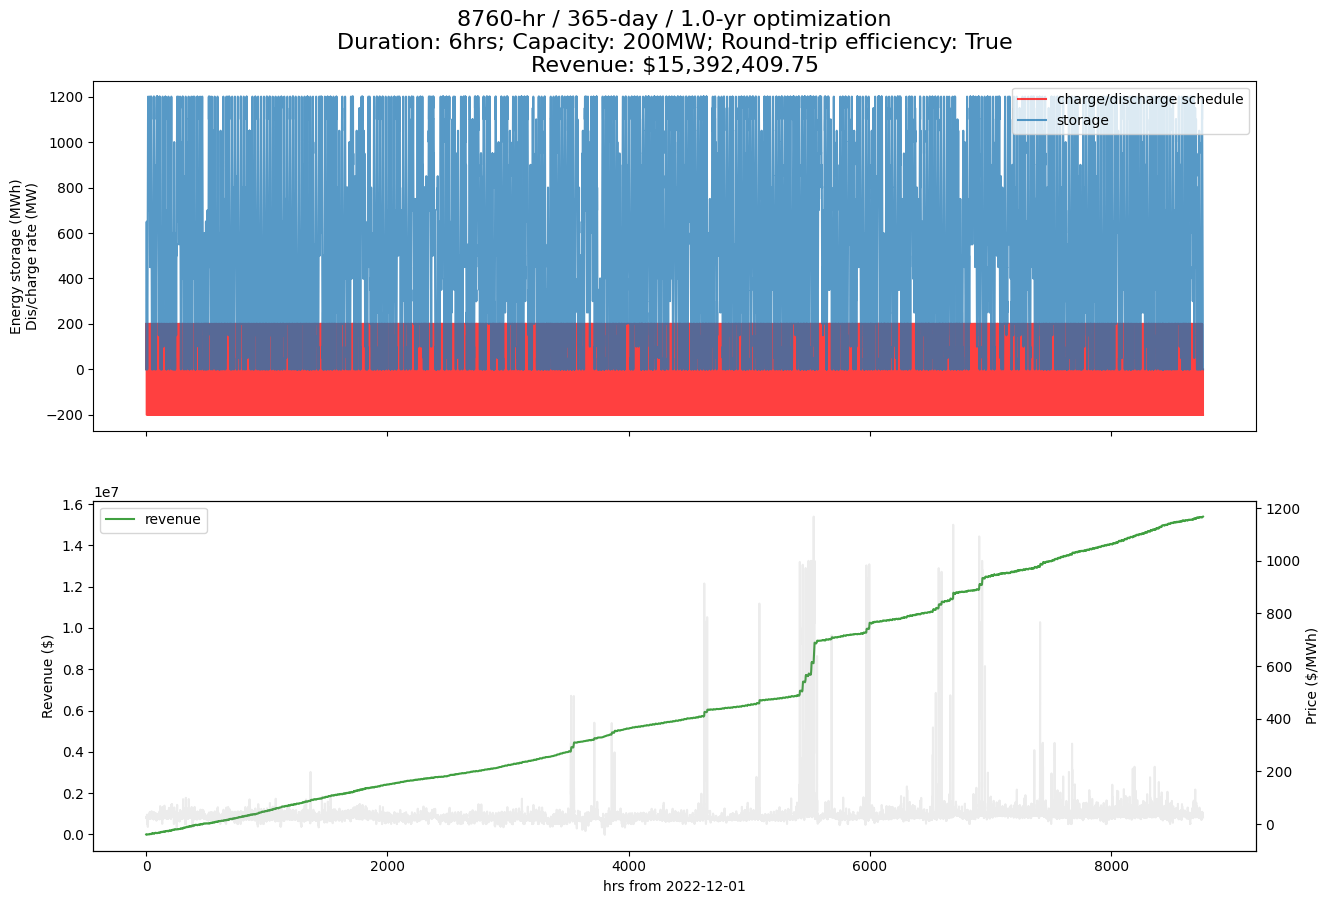

In [244]:
plot_optimal_performance(pn[t*y:t*(y+1)], dt_start=dt_start, 
                         duration=6, capacity=capacity, use_efficiency=True)

## 1.c Look at relationship between revenue and duration

### One year (actual efficiencies)

In [125]:
t = 4*24*30*12
p = pn[:t]
cap_step, dur_step = 60, 5
cap_max, dur_max = 300, 100
durations = np.arange(1, dur_max + dur_step, dur_step)
capacities = np.arange(cap_step, cap_max + cap_step, cap_step)
log = np.zeros((len(capacities), len(durations)))
for i, cap in enumerate(tqdm(capacities)):
    for j, dur in enumerate(durations):
        __, __, __, log[i, j] = get_battery_schedule(p, duration=dur, charge_capacity=cap, use_efficiency=True)
        

100%|█████████████████████████████████████████████| 5/5 [03:47<00:00, 45.60s/it]


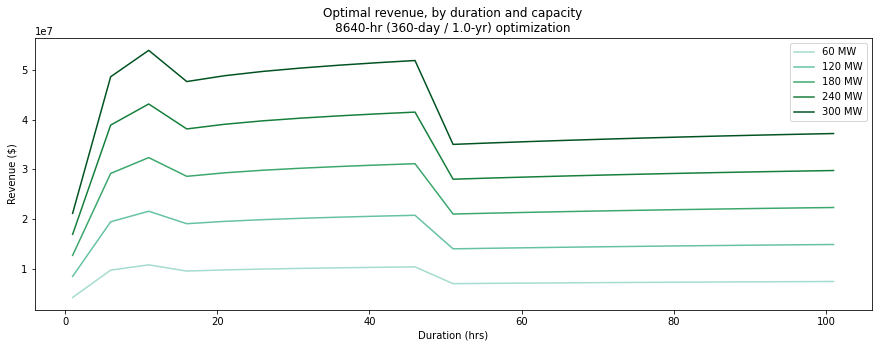

In [126]:
# plot
colors = plt.cm.BuGn(np.linspace(0.35,0.95,log.shape[0]))

fig = plt.figure(figsize=(15, 5))
for i, cap in enumerate(log):
    plt.plot(durations, cap, color=colors[i], label=f'{(i+1)*cap_step} MW')
    
plt.title(f'Optimal revenue, by duration and capacity\n{int(t/4)}-hr / {int(t/4/24)}-day / {np.round(t/4/24/365, 1)}-yr optimization')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

### One year (perfect efficiency)

In [127]:
t = 4*24*30*12
p = pn[:t]
cap_step, dur_step = 60, 5
cap_max, dur_max = 300, 100
durations = np.arange(1, dur_max + dur_step, dur_step)
capacities = np.arange(cap_step, cap_max + cap_step, cap_step)
log = np.zeros((len(capacities), len(durations)))
for i, cap in enumerate(tqdm(capacities)):
    for j, dur in enumerate(durations):
        __, __, __, log[i, j] = get_battery_schedule(p, duration=dur, charge_capacity=cap, use_efficiency=False)

100%|█████████████████████████████████████████████| 5/5 [03:15<00:00, 39.03s/it]


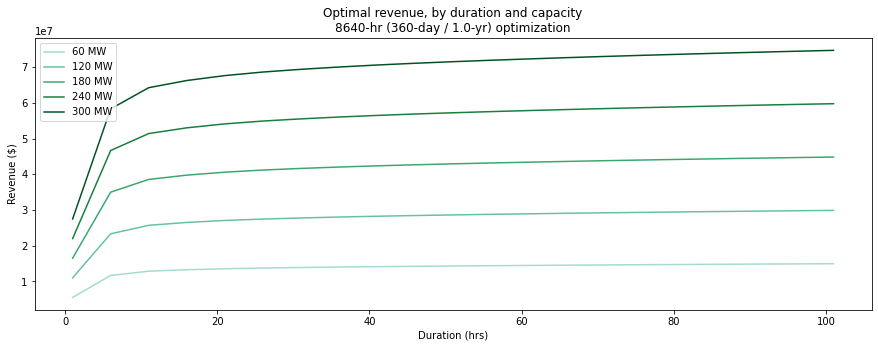

In [128]:
colors = plt.cm.BuGn(np.linspace(0.35,0.95,log.shape[0]))

fig = plt.figure(figsize=(15, 5))
for i, cap in enumerate(log):
    plt.plot(durations, cap, color=colors[i], label=f'{(i+1)*cap_step} MW')
    
plt.title(f'Optimal revenue, by duration and capacity\n{int(t/4)}-hr ({int(t/4/24)}-day / {np.round(t/4/24/365, 1)}-yr) optimization')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

# 2. Are there periods when long-duration outperforms?

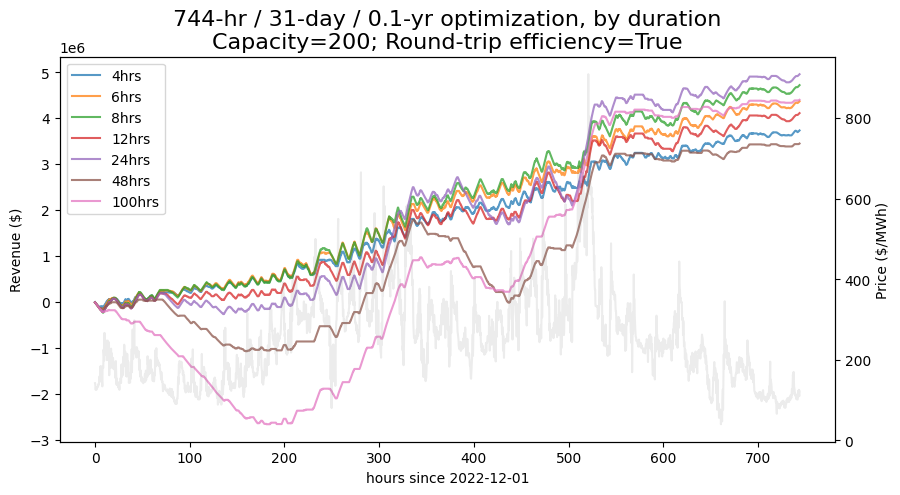

In [257]:
# find highest volatility months and other stand-out time periods
stat = 'median'
summ = data.groupby(['location', 'month', 'year'])['lmp'].agg([stat]).reset_index()

# visualize
max_values = summ.loc[summ[stat] == summ[stat].max()].values[0]
data_volatile = data.loc[(data.month == max_values[1]) & 
                        (data.year == max_values[2]) &
                        (data.location == max_values[0])]

dt_start = data_volatile.datetime.min().date()
p = data_volatile.lmp.values
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, True)

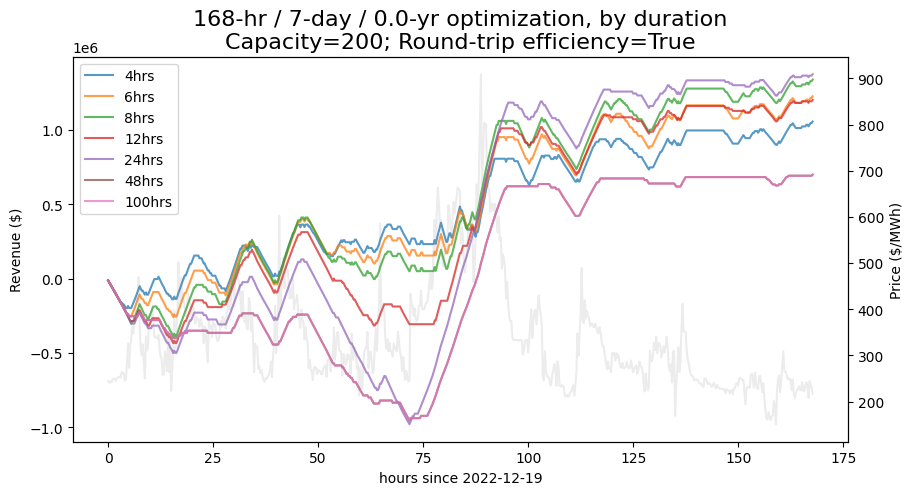

In [264]:
# find highest volatility months and other stand-out time periods
stat = 'median'
summ = data.groupby(['location', 'week', 'year'])['lmp'].agg([stat]).reset_index()

max_values = summ.loc[summ[stat] == summ[stat].max()].values[0]
data_volatile = data.loc[(data.week == max_values[1]) & 
                        (data.year == max_values[2]) &
                        (data.location == max_values[0])]

dt_start = data_volatile.datetime.min().date()
p = data_volatile.lmp.values
plot_optimal_rev_by_duration(p, dt_start, durations, capacity, True)